<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objetive" data-toc-modified-id="Objetive-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objetive</a></span></li><li><span><a href="#Experiment-Overview" data-toc-modified-id="Experiment-Overview-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Experiment Overview</a></span></li></ul></div>

# Imports

/Users/c83661a/Documents/github/imbalanced_learning/notebooks


In [20]:
# basic imports

import numpy as np
import pandas as pd


# specifc imports

import optuna 


import plotly.express as px

import shap

In [25]:
# configuring the plots
# I added all those plot setting in this script and 
# you might use it, or make you own version.
%run -i '../../src/utils/plot_config.py'

# output image quality
%config InlineBackend.figure_format = 'retina'

cmap_serasa = matplotlib.colors.LinearSegmentedColormap.from_list("", [pal[1],pal[0]])

# Load datasets

In [2]:
########################
# DATA FILE NAME IN CSV
datafile='../data/polish_companies_bankruptcy_1o_year.csv'
########################

df = pd.read_csv(datafile)

print(df.shape)

print(df.shape)

features = list(df.columns)
features.remove('class')

df.head()

(7027, 65)
(7027, 65)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


In [3]:
# feature description

fdescr  = open('../data/polish_data_description.txt','r')

feature_description = {}
for line in fdescr.readlines():
    d = line.split(' ')
    feature_description[d[0]] = ' '.join(d[1:]).replace('\n','')

In [4]:
for k,v in feature_description.items():
    print(k,': ',v)

X1 :  net profit / total assets
X2 :  total liabilities / total assets
X3 :  working capital / total assets
X4 :  current assets / short-term liabilities
X5 :  [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
X6 :  retained earnings / total assets
X7 :  EBIT / total assets
X8 :  book value of equity / total liabilities
X9 :  sales / total assets
X10 :  equity / total assets
X11 :  (gross profit + extraordinary items + financial expenses) / total assets
X12 :  gross profit / short-term liabilities
X13 :  (gross profit + depreciation) / sales
X14 :  (gross profit + interest) / total assets
X15 :  (total liabilities * 365) / (gross profit + depreciation)
X16 :  (gross profit + depreciation) / total liabilities
X17 :  total assets / total liabilities
X18 :  gross profit / total assets
X19 :  gross profit / sales
X20 :  (inventory * 365) / sales
X21 :  sales (n) / sales (n-1)
X22 :  profit on operating activities / total ass

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = df[features]
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [7]:
print('train p(b) = %.3f ' %y_train.mean() )
print('test p(b) = %.3f ' %y_test.mean() )

train p(b) = 0.041 
test p(b) = 0.034 


Definetily a imbalanced case.

# Experiment



# xgboost

In [8]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

In [9]:
def objective_xgb(trial, X, y):
    """Define objective function for hyperparameter optimization
    Parameters
    ----------
    trial:
    data:
    model:
    
    Returns
    -------
    metric: float
    """

    # Suggest values of the hyperparameters using a trial object.
    params = {'eval_metric': 'logloss',
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
                  'max_depth': trial.suggest_int('max_depth', 1, 20),
                  'n_estimators': trial.suggest_int('n_estimators', 1, 1000),
#                  'criterion' : trial.suggest_categorical('criterion' ,['gini', 'entropy'])
                  'reg_alpha': 0.5,
                  'reg_lambda': 0.5,
                  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 1e-4, 1),
#                   'early_stopping_rounds': 20,
                  'min_child_weight': trial.suggest_int('min_child_weight', 2,10),
                  'gamma': trial.suggest_int('gamma', 3, 8)}
    
    base_model = xgb.XGBClassifier(n_jobs=10, 
                                   tree_method='hist', 
                                   predictor='cpu_predictor',
                                   use_label_encoder=False)

    model = base_model.set_params(**params)
    
    skf = StratifiedKFold(n_splits=10, shuffle = True)
    
    m1_scores = cross_val_score(model, X, y, scoring= 'roc_auc', cv=skf.split(X, y,), n_jobs=10)
    m2_scores = cross_val_score(model, X, y, scoring= 'average_precision', cv=skf.split(X, y), n_jobs=10)  
    
    # see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    
    return np.median(m1_scores), np.median(m2_scores)

In [11]:

study_2o = optuna.create_study(study_name= "auc_prec", 
                                    directions= ['maximize','maximize'],
                                    pruner = optuna.pruners.MedianPruner(
                                    n_startup_trials=10, n_warmup_steps=30, interval_steps=10),
                                    sampler = optuna.samplers.NSGAIISampler(),)


[I 2022-03-18 15:33:38,246] A new study created in memory with name: auc_prec


In [13]:
study_2o.optimize(lambda trial: objective_xgb(trial, 
                                       X = X_train,
                                       y = y_train),
                                       n_trials=5)

[I 2022-03-18 15:35:35,360] Trial 3 finished with values: [0.9396716101694915, 0.713170237930521] and parameters: {'learning_rate': 0.36881451887242345, 'max_depth': 12, 'n_estimators': 223, 'colsample_bytree': 0.7160948546676232, 'min_child_weight': 7, 'gamma': 4}. 
[I 2022-03-18 15:36:05,076] Trial 4 finished with values: [0.9245762711864405, 0.6976519044833154] and parameters: {'learning_rate': 0.009655427507495743, 'max_depth': 7, 'n_estimators': 436, 'colsample_bytree': 0.46681827181967556, 'min_child_weight': 9, 'gamma': 5}. 
[I 2022-03-18 15:36:12,433] Trial 5 finished with values: [0.9351694915254237, 0.7381020932016708] and parameters: {'learning_rate': 0.6217887550306967, 'max_depth': 19, 'n_estimators': 160, 'colsample_bytree': 0.5032257715110752, 'min_child_weight': 6, 'gamma': 3}. 
[I 2022-03-18 15:36:25,269] Trial 6 finished with values: [0.9192456997373062, 0.6850194984233497] and parameters: {'learning_rate': 0.4592341707952134, 'max_depth': 20, 'n_estimators': 358, 'co

In [14]:
# study = pickle.load( open( "model_study.pickle", "rb" ) )

df_study = study_2o.trials_dataframe()

df_study.sample(3)

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,system_attrs_nsga2:generation,state
5,5,0.935169,0.738102,2022-03-18 15:36:05.077909,2022-03-18 15:36:12.433165,0 days 00:00:07.355256,0.503226,3,0.621789,19,6,160,0,COMPLETE
1,1,0.906827,0.669068,2022-03-18 15:34:17.318639,2022-03-18 15:34:53.931200,0 days 00:00:36.612561,0.834117,8,0.005259,13,8,551,0,COMPLETE
4,4,0.924576,0.697652,2022-03-18 15:35:35.362530,2022-03-18 15:36:05.076670,0 days 00:00:29.714140,0.466818,5,0.009655,7,9,436,0,COMPLETE


In [15]:

fig = px.scatter(df_study,
                 x='values_0',y='values_1',
#                  error_x='values_1',
#                  color='params_classifier_method',
                 size='params_max_depth',
#                  symbol="sampler",
                 
                 labels={'params_n_estimators':'n_estimators',
                         'params_max_depth':'max_depth',
                         'params_classifier_method':'classifier',
                         'params_imputer_method':'imputer',
                          'values_0':'roc_auc',
                          'values_1':'avg_prec'},
                 hover_name='number',
                 color_continuous_scale='bluered')

# fig.add_vline(x=basemodel_logloss,
#              annotation_text="model baseline", 
#              annotation_position="top right")

fig.update_layout(
    title="Multi-Objective Optimization",
#     xaxis_title="FPR",
#     yaxis_title="TPR",
    font_size=18)
    
fig.show()

## explanations

In [18]:
selected_models = [5,7]

moo_model = {}

for i in selected_models:
    print("- Fitting moo model %4d" %i)
    base_model = xgb.XGBClassifier(n_jobs=5, tree_method='hist', predictor='cpu_predictor')
    moo_model[i] = base_model.set_params(**study_2o.trials[i].params)

    eval_set = [(X_train, y_train), (X_test, y_test)]

    moo_model[i].fit(X_train, y_train,
          verbose=False,
#           eval_metric='auc',
          eval_metric=['error','auc','logloss'],
#           eval_metric=['error','logloss','auc'],
          eval_set=eval_set,
           early_stopping_rounds=20)

- Fitting moo model    5


/opt/anaconda3/envs/ulam/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



- Fitting moo model    7


In [21]:
moo_explainer = {}
moo_shap_values = {}
for i in selected_models:
    print("- Calculating shap values for moo model %4d" %i)
    moo_explainer[i] = shap.TreeExplainer(moo_model[i])
    moo_shap_values[i] = moo_explainer[i].shap_values(X_train)

- Calculating shap values for moo model    5
- Calculating shap values for moo model    7


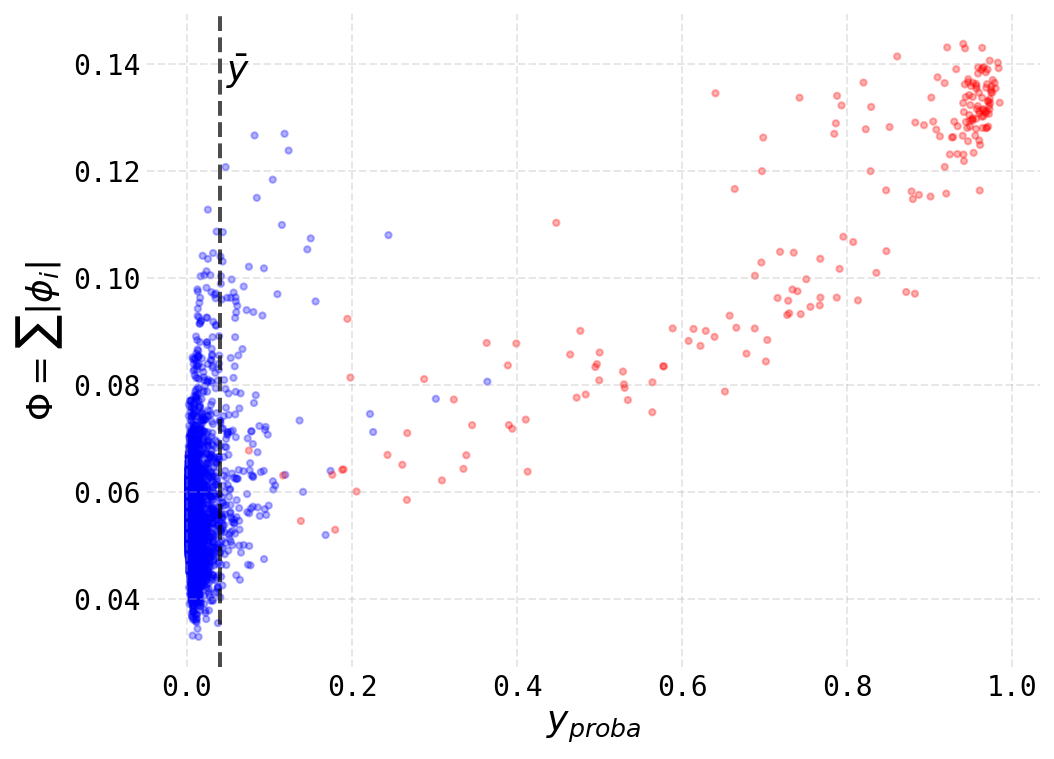

In [53]:
selected_models_here = selected_models
selected_models_here = [7]

fig, ax = plt.subplots()

mi = 7
Odds = (y_pred_moo[mi]+1e-8)/y_train.mean()
logOdds = np.log10(Odds)
pred_logOdds_moo[mi] = logOdds
    
    
ax.scatter(y_pred_moo[mi],C_moo[mi],c=y_train.values,cmap=cmap,s=10,alpha=0.3)
#ax.scatter(logOdds,C_moo[mi],c=y_train.values,cmap=cmap,s=10,alpha=0.2)
    
label = 'def. rate = %.2f' %y_train.mean()
y_bar = y_train.mean()
ax.axvline(x=y_bar,ls='--',color='k',alpha=0.7,lw=2,label=label)
ax.text(x=1.15*y_bar,y=0.95*np.max(C_moo[mi]),s=r'$\bar{y}$', fontsize=18 )

    
ax.set_xlabel('$y_{proba}$',fontsize=18)

ax.set_ylabel('$\Phi = \sum |\phi_i|$',fontsize=18)
#axs[i].set_title("model #%d  (max_depth = %3d)" %(mi,dict_params['max_depth']),fontsize=18)
    
ax = clean_ax(ax,n=4)
ax.grid(True, axis='both', alpha=0.3, lw=1, ls='--')
ax.tick_params(length=0)

fig.savefig('figures/evanildo/tfi_vs_yproba1.png', transparent=True)

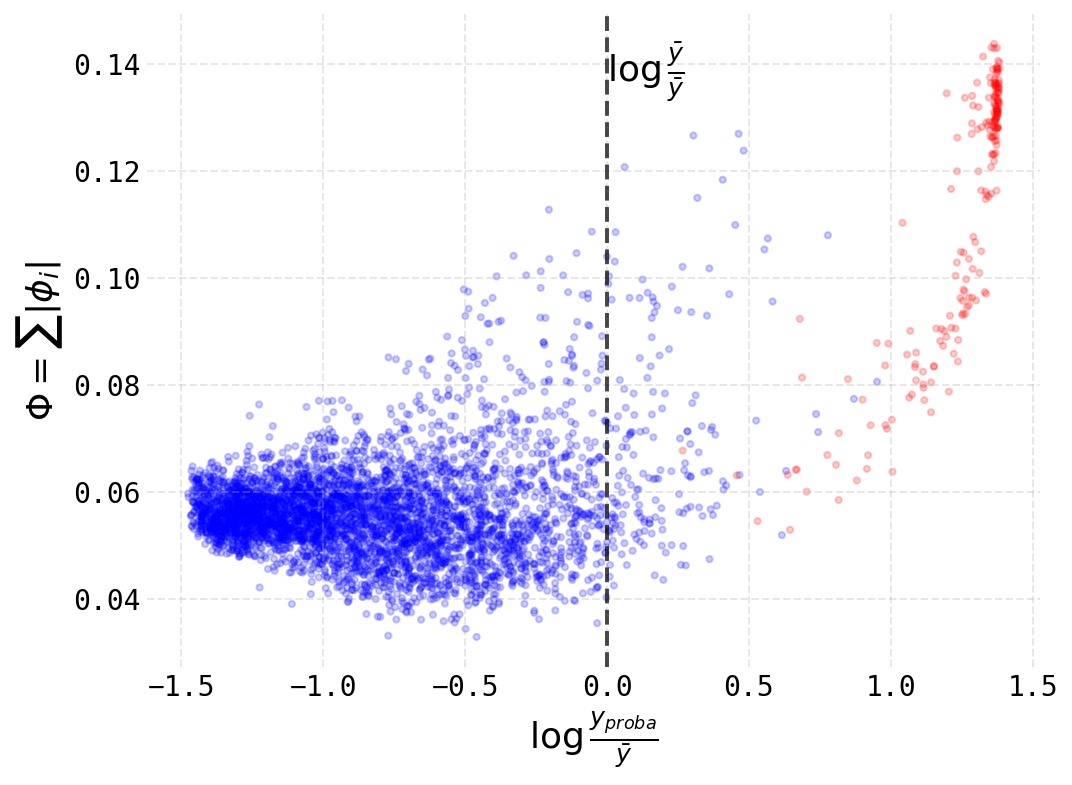

In [59]:
selected_models_here = selected_models
selected_models_here = [7]

fig, ax = plt.subplots()

mi = 7
Odds = (y_pred_moo[mi]+1e-8)/y_train.mean()
logOdds = np.log10(Odds)
pred_logOdds_moo[mi] = logOdds
    
    
# ax.scatter(y_pred_moo[mi],C_moo[mi],c=y_train.values,cmap=cmap,s=10,alpha=0.3)
ax.scatter(logOdds,C_moo[mi],c=y_train.values,cmap=cmap,s=10,alpha=0.2)
    
label = 'def. rate = %.2f' %y_train.mean()
y_bar = y_train.mean()
ax.axvline(x=0,ls='--',color='k',alpha=0.7,lw=2,label=label)
ax.text(x=0,y=0.95*np.max(C_moo[mi]),s=r'$\log \frac{\bar{y}}{\bar{y}}$', fontsize=18 )

    
ax.set_xlabel(r'$\log\frac{y_{proba}}{\bar{y}}$',fontsize=18)

ax.set_ylabel('$\Phi = \sum |\phi_i|$',fontsize=18)
#axs[i].set_title("model #%d  (max_depth = %3d)" %(mi,dict_params['max_depth']),fontsize=18)
    
ax = clean_ax(ax,n=4)
ax.grid(True, axis='both', alpha=0.3, lw=1, ls='--')
ax.tick_params(length=0)

fig.savefig('figures/evanildo/tfi_vs_yproba1_log.png', transparent=True)

# Conclusions

Summaize here the main results

# Explanations 

## Intro


Modern day machine learning models can be very complex, having even millions of parameters and many mathematical operations coupling the input variables. For instance a model such as Rnadom Forest can contain hundreds of decision trees with variate deep that are combined to produce a single output number. Similarly, neural networks might have many layers that couple the input variable using a collecion of mathematical operations. In simpler models such as logistic regression, one can easily infer the impact of a particular feature looking at the related coeficient, such approach is impossible for hifh performance models such as multi-layer neural networks and random forest. 

In  high stakes situations such as credit risk modelling it is essencial not only produce good models but also to be able verify how the input features impact the predictions. For complex models, one can tackle this challege using the so called *explainers*. Many explainers are simpler models that locally approximate the predictions of more complex models. The SHAP (Shapley Additive Explanations) explainer lib, for instance, use ideias from game theory to quantify the impact of each feature. 

In mathematical terms, we want to undertand the impact of the vector input $x$ for the prediction produced by a complex model $f$ using a explanation model $g$.  This explanation model will be a linear function of a simplified binary input $x'$, that is

$$
f(x) \approx g(x') = \phi_0 + \sum_{i=1}^N \phi_i x'_i   
%\label{eq:shaps}
$$
where $x'\in \{0,1\}^N$, N is the number of features, and $\phi_i \in \mathcal{R}$ is the feature impact. If $x'_i=0$ than $\phi_i$ is also zero. The $\phi_0$ is the $E[f]_{x\sim \hat{P}}$, and $\hat{P}$ the empirical distribution from the data. 


In the following we will study of effect of the imbalance in the $\phi_i$ values. 

## Explanations for imbalanced datasets

Let's consider a binary classification problem with a training set $\{(x_i,y_i)\}_{i=1}^M$, where  $x_i$ is the feature vector and $y_i$ the labels. We set $y_i=1$ for the minority class. 


### What to expect for $\phi_0$. 
In eq.\ref{eq:shaps} $\phi_0$ is the average value of $E[f]$, which is expected to be close to $\bar{y}$. If $\bar{y}$ is small most $\phi_i$ values tend to be high so eq.\ref{eq:shaps} is satisfied when $y_i = 1$. As a way to visualize this behavior let's consider the sum of absolute shape values

$$
\Phi = \sum_{i=1}^N |\phi_i|. 
$$
The value $\Phi$ represents the total feature impact on the prediction $\hat{y}_i$. If no feature has impact on $\hat{y}_i$, than $\Phi \rightarrow 0$ and   $g(x') \rightarrow \phi_0$. In  Fgure XXX we can see a example of this behavior. 

<img src='figures/evanildo/tfi_vs_yproba1.png'>

For imbalanced datasets, we might use $y_{proba}/\bar{y}$ or better yet $\log (y_{proba}/\bar{y})$. The new plot shows more simmetry around the $\bar{y}$ value. 

[!teste](figures/evanildo/tfi_vs_yproba1_log.png)

%Relationship between the sum of absolute impacts and $y_{proba}$. 

%Adjusted metric $log(y_{proba}/\bar{y})$


